In [2]:
# Set Theano flags to avoid BLAS config issues before importing pymc3/theano
import os
os.environ["THEANO_FLAGS"] = "blas__ldflags= "
os.environ.setdefault("OMP_NUM_THREADS", "1")
print("Set THEANO_FLAGS=", os.environ["THEANO_FLAGS"])



Set THEANO_FLAGS= blas__ldflags= 


In [3]:
import csv
import pandas as pd
import numpy as np

df=pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_train.csv')


mean=df.iloc[:, 1:].mean().mean()
std=df.iloc[:, 1:].std().mean()
df_norm=(df.iloc[:, 1:]-mean)/std
df_norm.insert(0, 'label', df['label'])
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')
df_test_norm=(df_test.iloc[:, 1:]-mean)/std
df_test_norm.insert(0, 'label', df_test['label'])

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the DataFrame
def display_images(df, indices, figsize=(12, 8)):
    
    n_images = len(indices)
    cols = min(5, n_images)  # Maximum 5 columns
    rows = (n_images + cols - 1) // cols  # Calculate rows needed
    
    plt.figure(figsize=figsize)
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        # Get the label and pixel data
        label = df.iloc[idx, 0]
        pixels = df.iloc[idx, 1:].values
        image = pixels.reshape(28, 28)
        
        plt.imshow(image, cmap='gray')
        plt.title(f'Index: {idx}, Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']    


Displaying one example from each class:


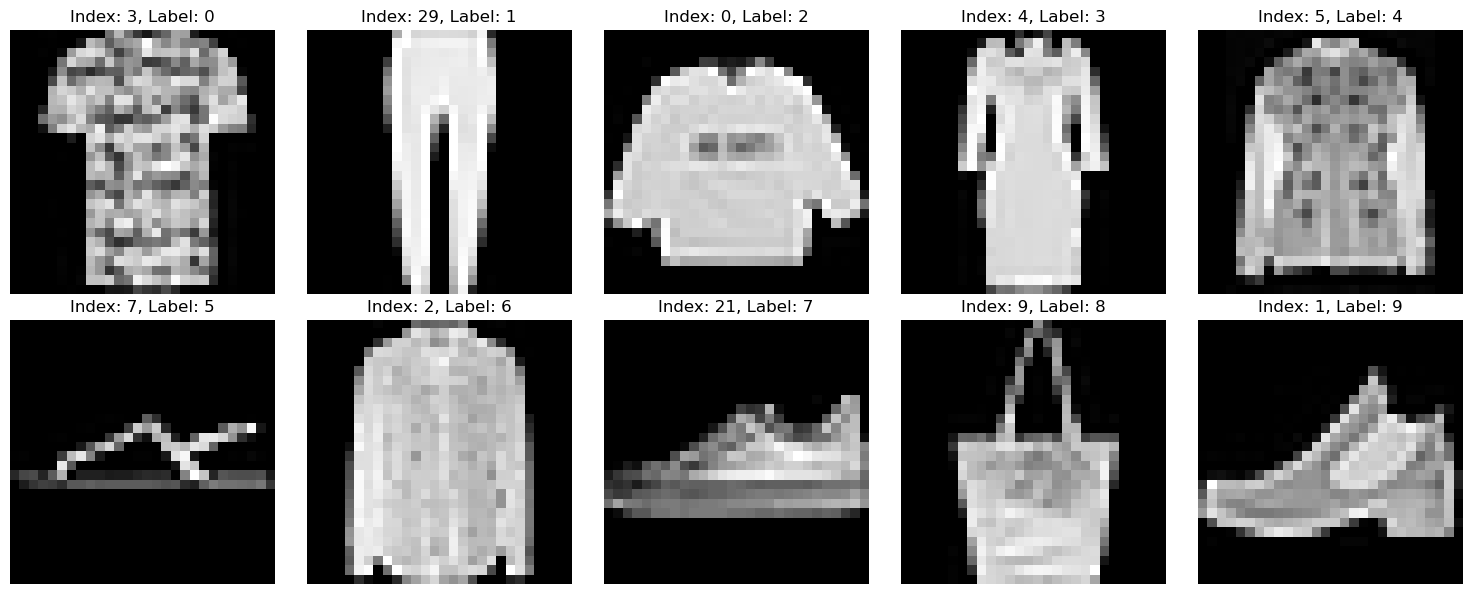

In [5]:
print("\nDisplaying one example from each class:")
one_per_class = []
for class_label in range(10):
    # collect indices of first occurrence of each class
    class_indices = df[df['label'] == class_label].index
    if len(class_indices) > 0:
        one_per_class.append(class_indices[0])
#display images 
display_images(df, one_per_class, figsize=(15, 6))        

In [6]:
# Load the test set
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')
print(f"Test dataset shape: {df_test.shape}")



Test dataset shape: (10000, 785)


In [7]:
def hide_random(df_norm, hide_ratio=0.75, hidden_value=0):
   
    # Separate label and pixel block
    labels = df_norm.iloc[:, 0].to_numpy(copy=True)
    pixels = df_norm.iloc[:, 1:].to_numpy(copy=True)  # shape: (n_rows, n_pixels)

    n_rows, n_pixels = pixels.shape

    # Randomly mask the pixels
    mask = (np.random.rand(n_rows, n_pixels) < hide_ratio)
    pixels[mask] = hidden_value

    # Rebuild DataFrame with original column names
    hidden_df = pd.DataFrame(pixels, columns=df_norm.columns[1:], index=df_norm.index)
    hidden_df.insert(0, 'label', labels)
    return hidden_df

In [8]:
def hide_continuous(df, hide=[0.25, 0.75], hidden_value=0):
    """
    Hides a percentage of pixels in a dataframe 
    and returns two dataframes with different masking levels.

    Args:
        df: Input dataframe
        hide (list): List of two hiding ratios
        hidden_value: The value to replace the hidden pixels with.

    Returns:
        tuple: (df_first, df_second) - Two dataframes with the specified hiddden value applied.
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    labels = df.iloc[:, 0].to_numpy()
    original_pixels = df.iloc[:, 1:].to_numpy(copy=True)  #copy to avoid modifying original df
    n_rows, n_pixels = original_pixels.shape
    
    hide_first_ratio = hide[0]
    hide_second_ratio = hide[1]

    #Calculate the number of pixels to hide for each ratio
    n_hide_first = int(n_pixels * hide_first_ratio)
    n_hide_second = int(n_pixels * hide_second_ratio)

    

    #Select indices to hide. We select the indices for the larger ratio first,
    # then use a subset of those for the smaller ratio.
    all_drop_indices = np.random.choice(
        n_pixels, 
        size=n_hide_second, 
        replace=False
    )
    
    # Indices for the smaller mask
    # Take the first n_hide_first elements of the larger set
    drop_indices_first = all_drop_indices[:n_hide_first] 
    
    # Indices for the larger mask 
    drop_indices_second = all_drop_indices 

    # first dataframe
    pixels_first = original_pixels.copy()
    # Mask rows at the selected columns
    pixels_first[:, drop_indices_first] = hidden_value 
    
    df_first = pd.DataFrame(
        pixels_first, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_first.insert(0, 'label', labels)
    
    # second dataframe
    pixels_second = original_pixels.copy()
    # Mask all rows at the selected columns
    pixels_second[:, drop_indices_second] = hidden_value
    
    df_second = pd.DataFrame(
        pixels_second, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_second.insert(0, 'label', labels)
    
    return df_first, df_second

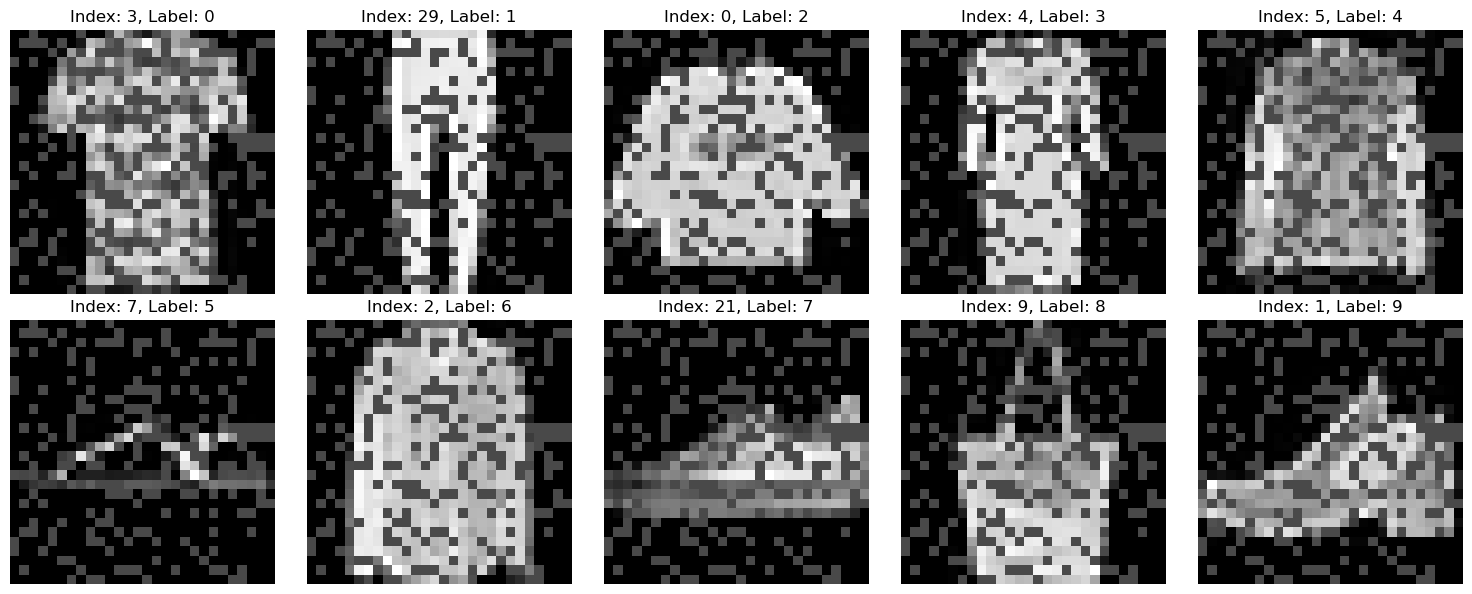

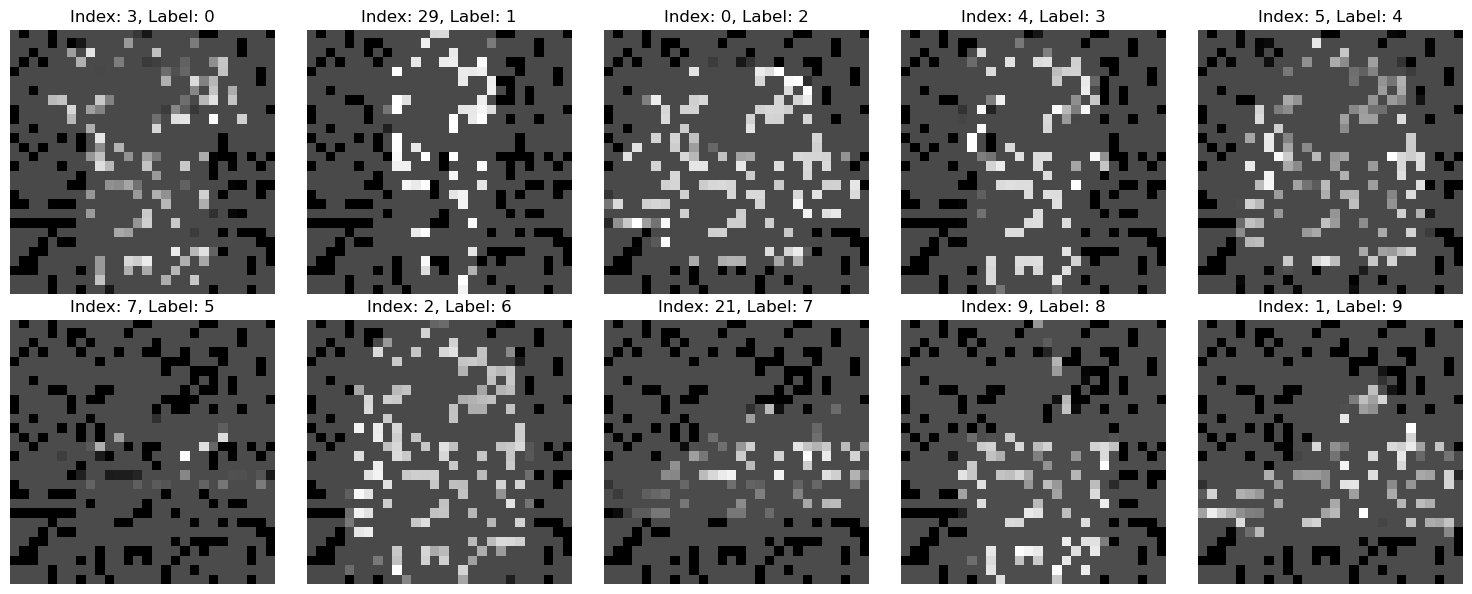

In [9]:
# original vs hidden comparison
df_cont1,df_cont2 = hide_continuous(df_norm, hide=[0.25, 0.75], hidden_value=0)

#display images     
display_images(df_cont1, one_per_class, figsize=(15, 6))
display_images(df_cont2, one_per_class, figsize=(15, 6))

## Bayesian Logistic Regression

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Prepare data for Bayesian Logistic Regression
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')
X_train=df_cont2.iloc[:, 1:]
y_train=df_cont2['label']
X_test=df_test.iloc[:, 1:]
y_test=df_test['label']
X_tr = X_train.to_numpy(dtype=np.float64)
X_te = X_test.to_numpy(dtype=np.float64)
y_tr = y_train.to_numpy()
y_te = y_test.to_numpy()

# Standardize features
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# PCA dimensionality reduction 
pca_components = 100  
pca = PCA(n_components=pca_components, random_state=42, svd_solver='randomized', whiten=False)
X_tr_s = pca.fit_transform(X_tr_s)
X_te_s = pca.transform(X_te_s)

# Ensure labels are 0..K-1 integers
classes, y_tr_enc = np.unique(y_tr, return_inverse=True)
class_to_index = {c: i for i, c in enumerate(classes)}
y_te_enc = np.vectorize(class_to_index.get)(y_te)
n_features = X_tr_s.shape[1]
n_classes = classes.shape[0]

# Clip to avoid huge logits early in training
X_tr_s = np.clip(X_tr_s, -10.0, 10.0)
X_te_s = np.clip(X_te_s, -10.0, 10.0)

# Bayesian Logistic Regression Model
with pm.Model() as blr_model:
    # Weight prior 
    W = pm.Normal('W', mu=0.0, sigma=0.3, shape=(n_features, n_classes))

    # Dirichlet prior for class probabilities
    alpha = np.bincount(y_tr_enc, minlength=n_classes) + 1.0
    pi = pm.Dirichlet('pi', a=alpha)

    # Linear logits and softmax with clipping to avoid overflow
    logits = tt.dot(X_tr_s, W) + tt.log(pi)
    logits = tt.clip(logits, -20.0, 20.0)
    p = tt.nnet.softmax(logits)

      
    y_obs = pm.Categorical('y_obs', p=p, observed=y_tr_enc)

    # Inference: ADVI with lower learning rate and callbacks
    approx = pm.fit(
        n=30000,
        method='advi',
        obj_optimizer=pm.adamax(learning_rate=5e-3),
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)],
        random_seed=42,
    )
    trace = approx.sample(2000)






<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Finished [100%]: Average Loss = 32,147


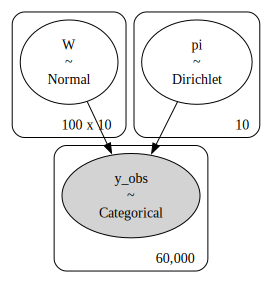

In [11]:
pm.model_to_graphviz(blr_model)

In [ ]:
# Posterior prediction
import numpy as np

# Softmax
def softmax_np(z, axis=-1):
    z_max = np.max(z, axis=axis, keepdims=True)
    e = np.exp(z - z_max)
    return e / np.sum(e, axis=axis, keepdims=True)

W_samples = trace['W']            # shape: (draws, n_features, n_classes)
pi_samples = trace['pi']          # shape: (draws, n_classes)

# Compute logits for each posterior draw on X_te_s
# logits[d, t, c] = X_te_s[t] @ W_samples[d, :, c] + log(pi_samples[d, c])
logits = np.einsum('tn,dnc->dtc', X_te_s, W_samples) + np.log(pi_samples)[:, None, :]
logits = np.clip(logits, -20.0, 20.0)

# Convert to probabilities and average across posterior draws
p_test_draws = softmax_np(logits, axis=-1)           # shape: (draws, n_test, n_classes)
p_test_mean = p_test_draws.mean(axis=0)              # shape: (n_test, n_classes)

# Predict labels and evaluate
y_pred_idx = p_test_mean.argmax(axis=1)              # indices 0..K-1
y_pred_labels = classes[y_pred_idx]                  # map back to original labels

test_accuracy = (y_pred_idx == y_te_enc).mean()
print(f"Test accuracy (posterior mean prediction): {test_accuracy:.4f}")


Test accuracy (posterior mean prediction): 0.3007
